Analysis of the LFPs in response to photostimulation

This notebook (LFP_Analysis_part1) follows the following pipeline:

1. Read ephys data
2. Filter the data (band-pass)
3. Align data to light pulses
4. Translate the data so that the moment of the pulse is at value 0
5. Test correlation with laser measurements of various elements in the LFP shapes
6. Generate an average LFP shape and save it

The code performs sanity checks and saves plots to illustrate the process


In [1]:
# See https://github.com/CINPLA/pyopenephys
%load_ext autoreload
%autoreload 2
import pyopenephys
from utils.custom_functions import *
import matplotlib.pylab as plt
import numpy as np
import math
import sys
import os
sys.path.append("../") # go to parent 
from BehaviouralAnalysis.utils.plot_utils import axvlines
import quantities as pq
from scipy.signal import filtfilt
import copy
import matplotlib
%matplotlib inline
import pickle

In [2]:
# 1. read data
GeneralDataDir = '/mnt/c/Users/herny/Desktop/SWC/Data/Ephys_data/LFP_Recordings/'
Experiment = 'Green_2019-05-02_15-59-17_LFP_auditNoPun_1mW'
file = pyopenephys.File(GeneralDataDir + Experiment)
experiments = file.experiments
experiment1 = experiments[0]
recordings = experiment1.recordings
recording = recordings[0]
analog_signals = recording.analog_signals
signals = analog_signals[0]
events_data = recording.events
events = events_data[0]
print('Duration: ', recording.duration)
print('Sampling Rate: ', recording.sample_rate)

Loading Open-Ephys: reading settings.xml...
Decoding data from  binary  format
.dat:  continuous.dat
Estimated samples:  21317632  Numchan:  43
Duration:  710.5876999999999 1/Hz
Sampling Rate:  30000.0 Hz


In [3]:
# Create output folder to save data
OutPutDir = GeneralDataDir + Experiment + '_AnalysisPart_1/'
if not os.path.isdir(OutPutDir):
    os.mkdir(OutPutDir)

In [4]:
# 2. filter the data
Filter_Low_Value = 100
Filter_High_Value = 1000
filteredData = copy.deepcopy(signals.signal)
#b,a = butter_lowpass(600, recording.sample_rate)
b,a = butter_bandpass(Filter_Low_Value, Filter_High_Value, recording.sample_rate)
for electrodeID in range(32):
    filteredData[electrodeID] = filtfilt(b, a, signals.signal[electrodeID])
    update_progress(electrodeID / 32)
update_progress(1)

Progress: [####################] 100.0%


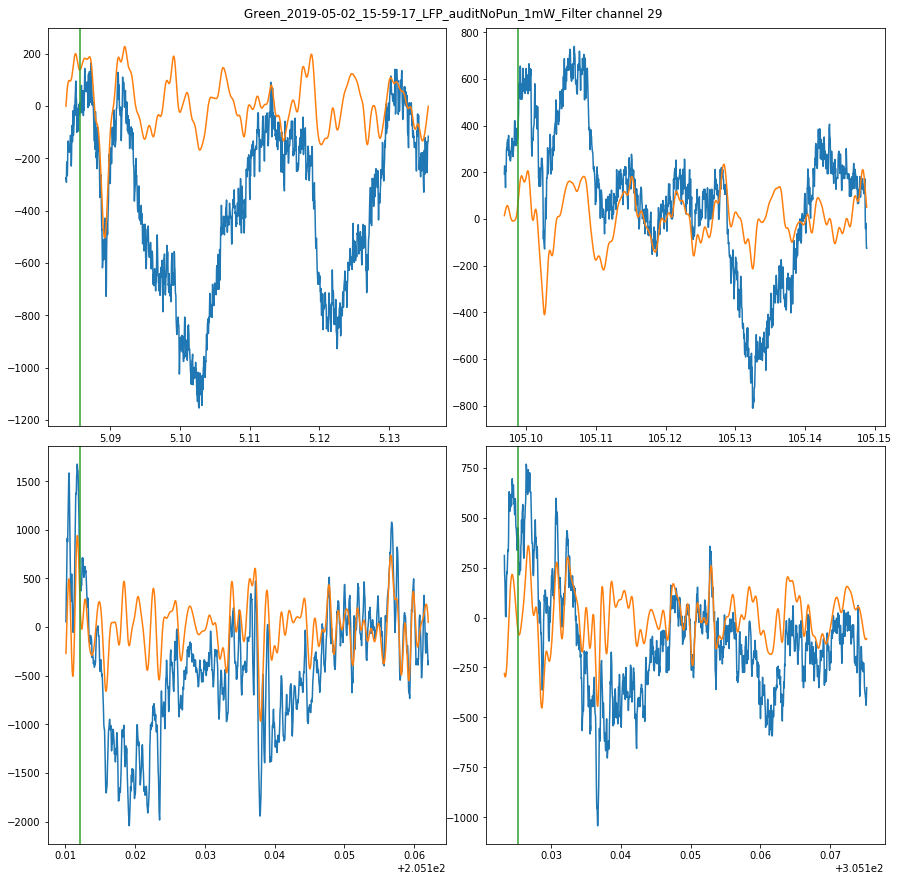

In [5]:
# Check point
# Check how the filtered data looks like
# Select a channel
ChId = 29
# Plot some examples (first, 10th, 20th and 30th pulse)
fig, axs = plt.subplots(2, 2, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .05, wspace=.1)
axs = axs.ravel()
plt.suptitle(Experiment + '_Filter channel ' + str(ChId), y=0.9)

for i in range(4):
    pulseTime = events.times[i*2*10].item() # *2 because TTLs come in pairs (beginning and end of pulse)
    pulseFrame = int(pulseTime * recording.sample_rate.item())
    pFS = int(pulseFrame - 0.002 * recording.sample_rate.item())
    pFF = int(pulseFrame + 0.05 * recording.sample_rate.item())
    #extract frames around the pulse
    axs[i].plot(signals.times[pFS:pFF],signals.signal[ChId][pFS:pFF])
    axs[i].plot(signals.times[pFS:pFF],filteredData[ChId][pFS:pFF])
    axvlines(pulseTime, ax = axs[i])

plt.savefig(OutPutDir + Experiment + '_FilteredSignal.pdf', transparent=True, bbox_inches='tight')
plt.show()

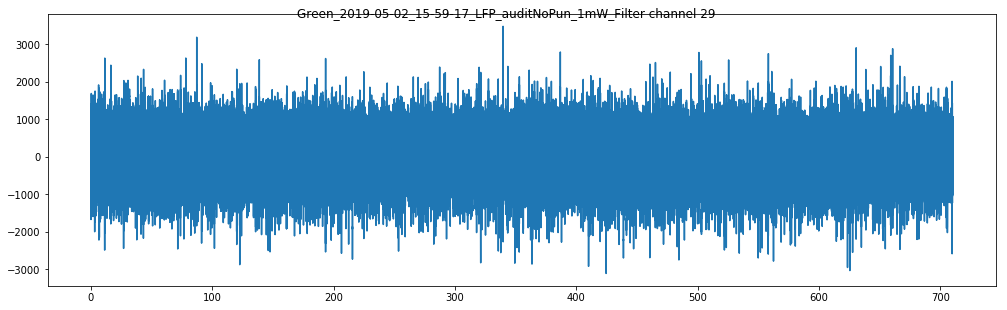

In [10]:
# Check point
# Check how the filtered data looks like
# Select a channel
ChId = 29
# Plot some examples (first, 10th, 20th and 30th pulse)
fig, axs = plt.subplots(1, 1, figsize=(17, 5), facecolor='w', edgecolor='k')
plt.suptitle(Experiment + '_Filter channel ' + str(ChId), y=0.9)
axs.plot(signals.times,signals.signal[ChId])
plt.show()

In [6]:
# 3. align data
# interval for traces alignment. In seconds. Range of alignment
intervalWindow = [-0.02,0.04]
firstpulses  = getFirstPulses(events.times, .5)
traces_aligned = alignTrace(filteredData, signals.times, firstpulses, intervalWindow, recording.sample_rate)
intervalTimes = np.arange(intervalWindow[0], intervalWindow[1], 1/recording.sample_rate.base)
print(Experiment + ' analyzed...')

Green_2019-05-02_15-59-17_LFP_auditNoPun_1mW analyzed...


In [7]:
# 4. translate data
# seconds to calculate the mean before 0 and translate each trace
sToSubstract = 0.005
traces_translated = copy.deepcopy(traces_aligned)
for electrodeID in range(len(traces_translated)):
    for traceID in range(len(traces_translated[electrodeID])):        
        traces_translated[electrodeID][traceID] = translateTrace(traces_aligned[electrodeID][traceID], intervalTimes, recording.sample_rate, sToSubstract)   
    update_progress(electrodeID / len(traces_translated))
update_progress(1)

Progress: [####################] 100.0%


Progress: [####################] 97.7%


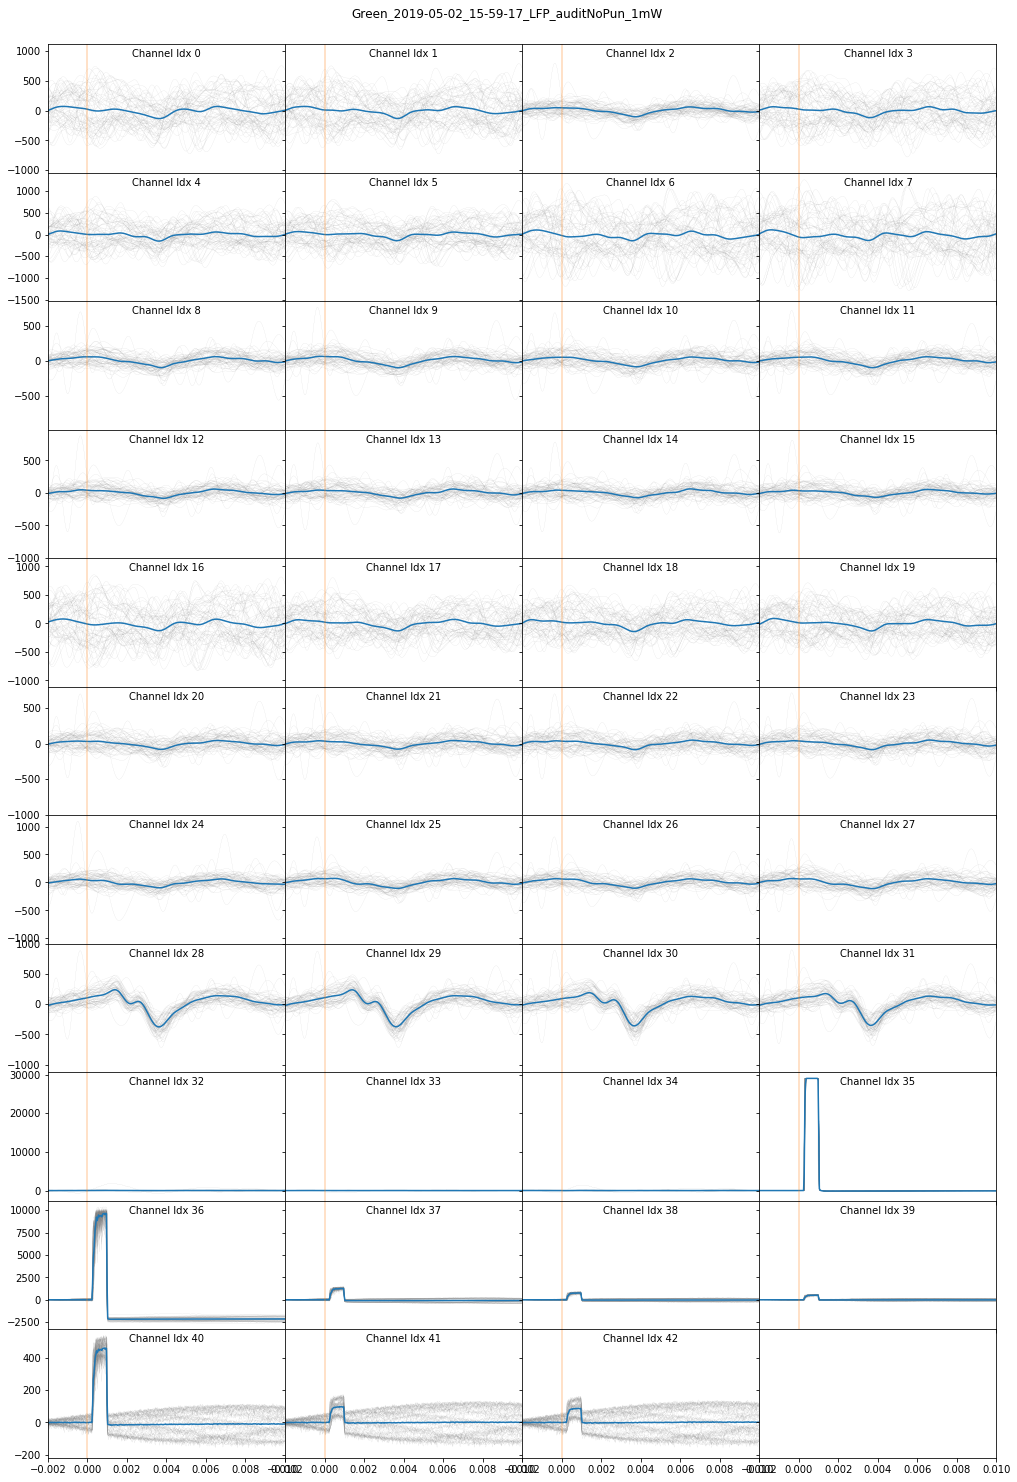

In [8]:
# Check-point. Plot the signal of each channel
fig, axs = plt.subplots(math.ceil(len(traces_translated)/4), 4, figsize=(17, 26), facecolor='w', edgecolor='k', sharex=True, sharey='row')
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
plt.suptitle(Experiment, y=0.9)

# Save the averages
Average_traces = [None] * len(traces_translated)

for j in range(len(traces_translated)):
    for i in range(traces_translated[j].shape[0]):
        axs[j].plot(intervalTimes, traces_translated[j][i,], color = 'grey', linewidth = 0.1, alpha = 0.6)
    avg = np.mean(traces_translated[j], axis = 0)
    Average_traces[j] = avg
    axs[j].plot(intervalTimes, avg)
    # zoom in the curve
    axs[j].set_xlim(-0.002, 0.01)
    axs[j].text(.5,.9,"Channel Idx "+str(signals.channel_id[j]), horizontalalignment='center', transform=axs[j].transAxes)
    update_progress(j / len(traces_translated))
    
for j in range(len(traces_translated)):    
    axvlines(0, alpha = 0.3, ax = axs[j])
    
plt.savefig(OutPutDir + Experiment + '_AlignedSignal.pdf', transparent=True, bbox_inches='tight')
plt.show()

/home/hmvergara/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1799 but corresponding boolean dimension is 1800
/home/hmvergara/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1799 but corresponding boolean dimension is 1800


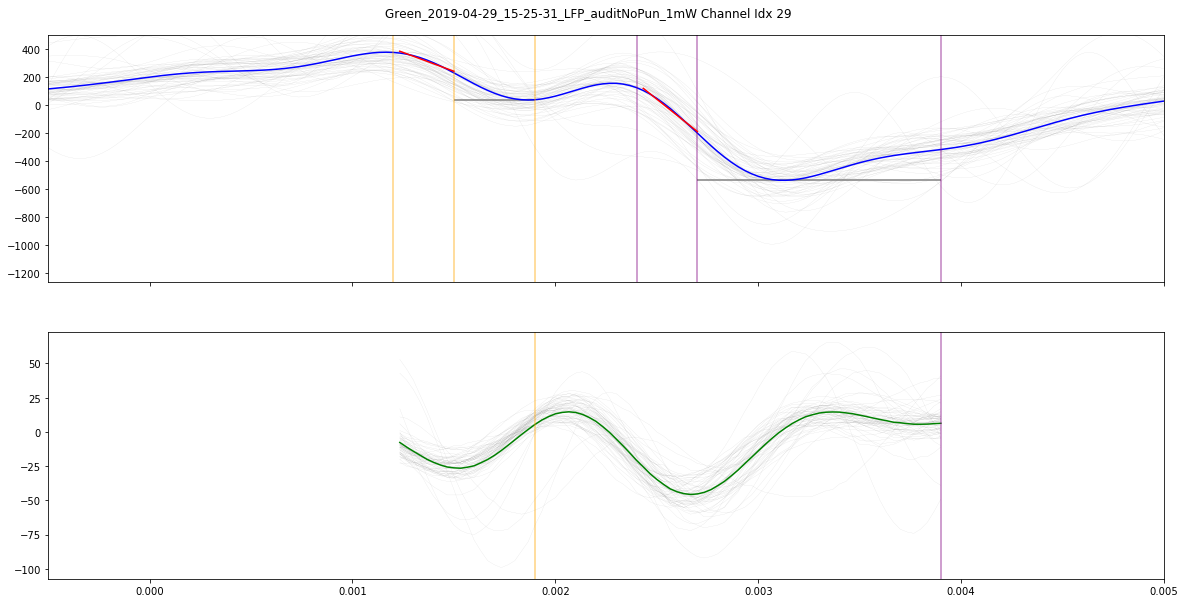

In [49]:
# 5. test correlations with the laser [OPTIONAL]
### matplotlib.style.use('ggplot')
# Select a channel index with a nice LFP shape to test correlations of the laser
ChxIdx = 29

# Adjust the following points to calculate parameters

pointC1 = 0.0012
pointC2 = 0.0015
pointC3 = 0.0019

pointN1 = 0.0024
pointN2 = 0.0027
pointN3 = 0.0039

LFPFrames = np.logical_and(intervalTimes>=pointC1, intervalTimes<=pointN3)

# Calculate important parameters of the average trace to see that it works
# minimum of the ChR2 bump
CminFrames = np.logical_and(intervalTimes>=pointC2, intervalTimes<=pointC3)
Cmin = np.min(Average_traces[ChxIdx][CminFrames])
# minimum of the neural bump
NminFrames = np.logical_and(intervalTimes>=pointN2, intervalTimes<=pointN3)
Nmin = np.min(Average_traces[ChxIdx][NminFrames])
# slope of neural bump
NlmFrames = np.logical_and(intervalTimes>=pointN1, intervalTimes<=pointN2)
NlinearModel = np.polyfit(x = intervalTimes[NlmFrames], y = Average_traces[ChxIdx][NlmFrames], deg=1)
Np = np.poly1d(NlinearModel)
# slope of ChR2 bump
ClmFrames = np.logical_and(intervalTimes>=pointC1, intervalTimes<=pointC2)
ClinearModel = np.polyfit(x = intervalTimes[ClmFrames], y = Average_traces[ChxIdx][ClmFrames], deg=1)
Cp = np.poly1d(ClinearModel)

fig_an, ax_an = plt.subplots(2,1,figsize=(20, 10), sharex=True)
for i in range(traces_translated[ChxIdx].shape[0]):
    ax_an[0].plot(intervalTimes, traces_translated[ChxIdx][i,], color = 'grey', linewidth = 0.1, alpha = 0.6)
ax_an[0].plot(intervalTimes, Average_traces[ChxIdx], color = 'blue')
ax_an[0].set_xlim(-0.0005, 0.005)
ax_an[0].set_ylim(ax_an[0].get_ylim()[0], 500)
axvlines(pointC1, alpha = 0.5, color = 'orange', ax = ax_an[0])
axvlines(pointC2, alpha = 0.5, color = 'orange', ax = ax_an[0])
axvlines(pointC3, alpha = 0.5, color = 'orange', ax = ax_an[0])
axvlines(pointN1, alpha = 0.5, color = 'purple', ax = ax_an[0])
axvlines(pointN2, alpha = 0.5, color = 'purple', ax = ax_an[0])
axvlines(pointN3, alpha = 0.5, color = 'purple', ax = ax_an[0])

ax_an[0].hlines(y = Cmin, xmin = pointC2, xmax = pointC3, alpha = 0.5)
ax_an[0].hlines(y = Nmin, xmin = pointN2, xmax = pointN3, alpha = 0.5)
ax_an[0].plot(intervalTimes[NlmFrames], Np(intervalTimes)[NlmFrames], color = 'red')
ax_an[0].plot(intervalTimes[ClmFrames], Cp(intervalTimes)[ClmFrames], color = 'red')

plt.suptitle(Experiment + " Channel Idx "+str(signals.channel_id[ChxIdx]), y=0.92)

# plot the derivative
DerminFrames = np.logical_and(intervalTimes>=pointN2, intervalTimes<=pointN3)
for i in range(traces_translated[ChxIdx].shape[0]):
    ax_an[1].plot(intervalTimes[LFPFrames], np.diff(traces_translated[ChxIdx][i,])[LFPFrames], color = 'grey', linewidth = 0.1, alpha = 0.6)
ax_an[1].plot(intervalTimes[LFPFrames], np.diff(Average_traces[ChxIdx])[LFPFrames], color = 'green')
axvlines(pointC3, alpha = 0.5, color = 'orange', ax = ax_an[1])
axvlines(pointN3, alpha = 0.5, color = 'purple', ax = ax_an[1])

plt.savefig(OutPutDir + Experiment + '_Correlations-pieces.pdf', transparent=True, bbox_inches='tight')
plt.show()

#restore plotting aesthetics
matplotlib.rcdefaults()

In [50]:
# Calculate these parameters for all traces
CminList = [None] * len(traces_translated[ChxIdx])
NminList = [None] * len(traces_translated[ChxIdx])
ClmSlopes = [None] * len(traces_translated[ChxIdx]) 
NlmSlopes = [None] * len(traces_translated[ChxIdx])
LFPminDerivative = [None] * len(traces_translated[ChxIdx])

for i in range(len(traces_translated[ChxIdx])):
    # minimum of the ChR2 bump
    Cmin = np.min(traces_translated[ChxIdx][i,][CminFrames])
    # minimum of the neural bump
    Nmin = np.min(traces_translated[ChxIdx][i,][NminFrames])
    # slope of neural bump
    NlinearModel = np.polyfit(x = intervalTimes[NlmFrames], y = traces_translated[ChxIdx][i,][NlmFrames], deg=1)
    # slope of ChR2 bump
    ClinearModel = np.polyfit(x = intervalTimes[ClmFrames], y = traces_translated[ChxIdx][i,][ClmFrames], deg=1)
    # max slope of Neural bump
    LFPminDerivative[i] = min(np.diff(traces_translated[ChxIdx][i,][DerminFrames]))
    
    
    CminList[i] = Cmin
    NminList[i] = Nmin
    ClmSlopes[i] = ClinearModel[0]
    NlmSlopes[i] = NlinearModel[0]
    
    update_progress(j / len(traces_translated))

update_progress(1)

Progress: [####################] 100.0%


In [51]:
# Get information for the laser
LaserIdx = 35
lengthOfPulse = int(0.0015 * recording.sample_rate) #pulses are 1ms, but the ttls do not correspond precisely to the analog signals of the laser intensity
ZeroFrame = np.where(intervalTimes > 0)[0][0] #frame in which time is zero
Laser_pulses = [x[ZeroFrame:(ZeroFrame+lengthOfPulse)] for x in traces_translated[LaserIdx]]
Laser_means = np.mean(Laser_pulses, axis = 1)
Laser_maxs = np.max(Laser_pulses, axis = 1)

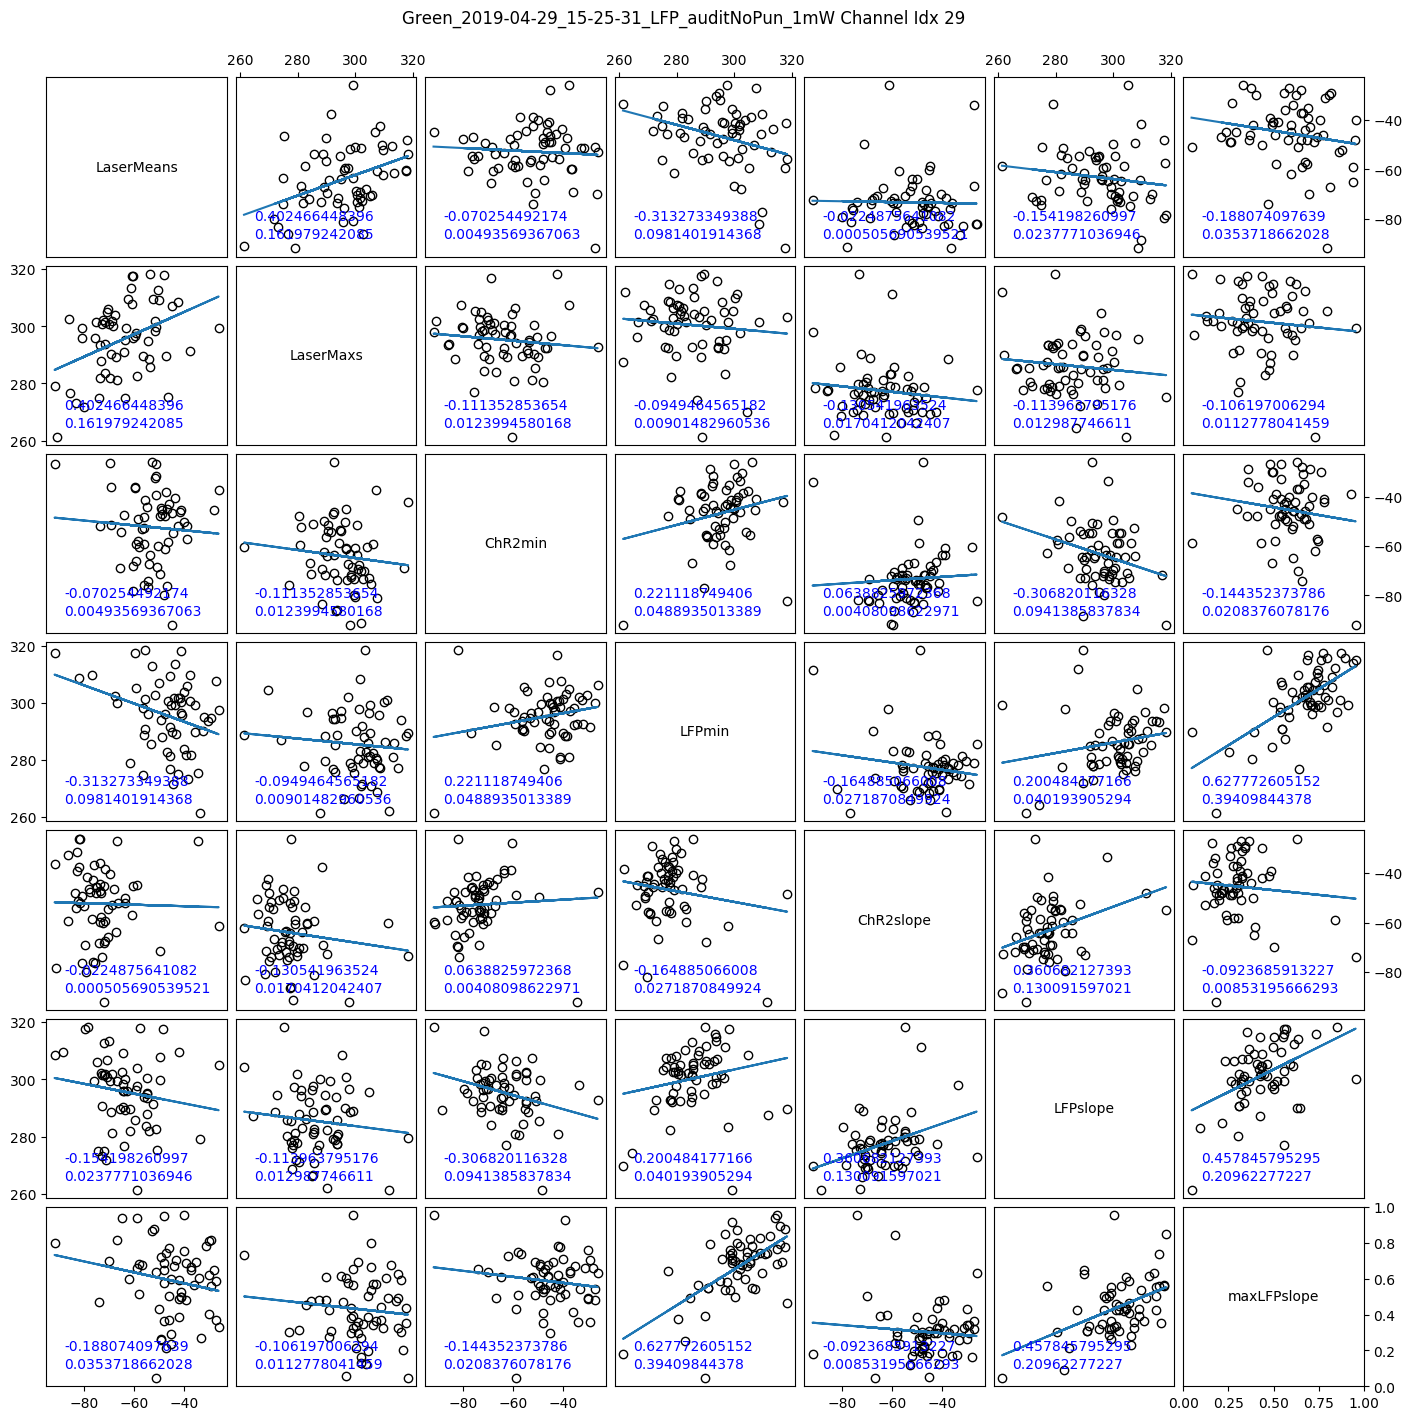

In [52]:
# Plot correlations of everything
CorrObjectsList = np.asarray([np.asarray(Laser_means), np.asarray(Laser_maxs), np.asarray(CminList), np.asarray(NminList), np.asarray(ClmSlopes), np.asarray(NlmSlopes), np.asarray(LFPminDerivative)])     
CorrObjectsNames = ['LaserMeans', 'LaserMaxs', 'ChR2min', 'LFPmin', 'ChR2slope', 'LFPslope', 'maxLFPslope']
fig = scatterplot_matrix(CorrObjectsList, CorrObjectsNames, linestyle='none', marker='o', color='black', mfc='none')
plt.suptitle(Experiment + " Channel Idx "+str(signals.channel_id[ChxIdx]), y=0.92)
plt.savefig(OutPutDir + Experiment + '_Correlations.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [9]:
# 6. Generate an average LFP shape and save it
with open(OutPutDir + Experiment + '_Analysis-1-data.pkl', 'wb') as f:
    pickle.dump([intervalTimes, Average_traces], f)
    
# Create a text file to store all parameters
with open(OutPutDir + Experiment + 'Analysis_1_data.txt', "w+" ) as f:
    f.write("Experiment name: {}\n".format(Experiment))
    f.write("Filtered values: [{}, {}]\n".format(Filter_Low_Value, Filter_High_Value))
    f.write("Aligned to window: [{}, {}]\n".format(intervalWindow[0], intervalWindow[1]))
    f.write("Seconds used for translation: {}\n".format(sToSubstract))